In [2]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
class Value:
    def __init__(self, data, _children =(), _op ='', label = '') -> None:
        self.data = data
        self.grad = 0.0
        self._backward = lambda:None # this is gonna do the chain rule
        self._prev = set(_children)
        self._op = _op
        self.label = label   
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data ,(self, other), '+')
        def _backward():
            self.grad  += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    def __radd__(self,other):
        return self + other

   
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data ,(self, other), '*')
        def _backward():
            self.grad  += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    def __rmul__(self, other):
        return self*other
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self, ), f'**{other}')
        def _backward():
            self.grad += other* (self.data **(other -1)) * out.grad
        out._backward = _backward
        return out
    
    def __neg__(self):
        return self*-1
    def __sub__(self, other):
        return self + (-other)

    def __truediv__(self, other):
        return self* other**-1
    
    def exp(self):
        x = self.data
        out = Value( math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
        
    def tanh(self):
        out = Value(math.tanh(self.data), (self, ), 'tanh')
        def _backward():
            self.grad += (1 - out.data**2)*out.grad
        out._backward = _backward
        return out
    def relu(self):
        out = Value(0 if self.data<0 else self.data, (self, ), 'ReLu')
        def _backward():
            self.grad = (out.data > 0) * out.grad
        out._backward = _backward
        return out
    
   
    #back-prop
    def backprop(self):
        # a topolical order of all the nodes
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        # apllying backward function from the end node to the beginning
        build_topo(self)
        self.grad =1.0
        for node in reversed(topo):
            node._backward()

In [19]:
p = Value(2)
r = Value(5)
q = 2
lits = [p.data**q, r.data**q]
sum(lits)

29

In [20]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))

        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:

            dot.node(name = uid + n._op, label=n._op)

            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:

        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

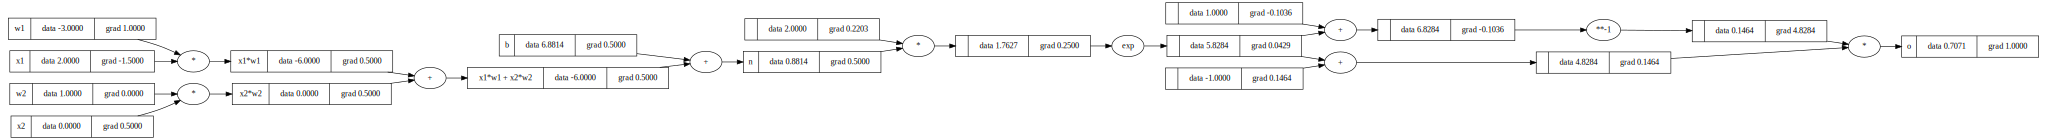

In [21]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backprop()
draw_dot(o)

In [22]:
from typing import Any


class Neuron:
    def __init__(self, nin) -> None:
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self, x) :
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP: # multi layer perceptron 
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer( sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [23]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)


Value(data=-0.3320698368964894)

In [24]:
xs = [
  [1.0, 3.0,],
  [2.0, -1.0],
]
ys = [1.0, -1.0] 
n = MLP(2, [2,2,1])
ypred = [n(x) for x in xs]


In [25]:
loss_lst = [ (ygt - yi)**2 for ygt, yi in zip(ypred, ys)]
loss = sum(loss_lst)
loss.grad = 1.0
loss.backprop()

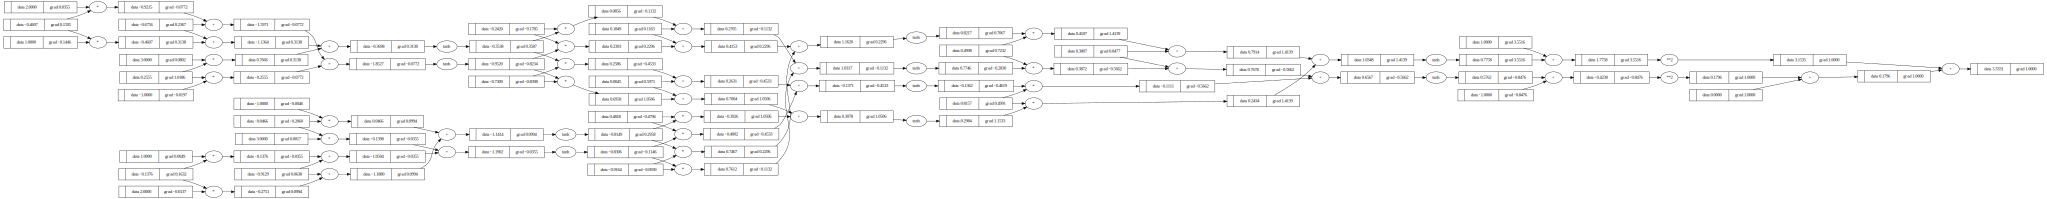

In [26]:
draw_dot(loss)

In [27]:
def adding(ypred):
    test = Value(0)
    for i,j in zip(ypred, ys):
        test += (i-j)**2
    return test

for k in range(5):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = adding(ypred)

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backprop()
    # update
    for p in n.parameters():
        p.data += -0.1 *p.grad
    
    print(k, loss.data)

0 3.333138591136691
1 2.88139148604013
2 2.2535166306907977
3 1.9321488644708467
4 1.7096010400003252


In [28]:
import torch

In [106]:
x1 = torch.Tensor([2.0]).double()   ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()   ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()   ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()   ; w2.requires_grad = True
b = torch.Tensor([6.88137]).double()
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071050214706146
---
x2 0.5000024886110417
w2 0.0
x1 -1.500007465833125
w1 1.0000049772220834


0